In [ ]:
!pip install efficientnet

     |████████████████████████████████| 51kB 7.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import cv2
import random
from matplotlib import pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Concatenate,Input,Reshape,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import random
from efficientnet.tfkeras import EfficientNetB2 as effn
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
train_dir = '/content/gdrive/My Drive/carla_adv/train'
test_dir = '/content/gdrive/My Drive/carla_adv/test'

(144, 256, 3)
[[128 139]
 [128 116]
 [128 102]
 [128  94]
 [128  90]
 [128  88]]
(144, 256, 3)
[[128 139]
 [128 139]
 [128 139]
 [128 139]
 [128 139]
 [128 139]]
(144, 256, 3)
[[128 139]
 [128 139]
 [128 139]
 [128 139]
 [128 139]
 [128 139]]
(144, 256, 3)
[[128 139]
 [128 139]
 [128 139]
 [128 139]
 [128 139]
 [128 139]]


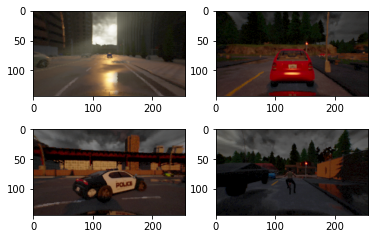

In [ ]:
images = os.listdir(train_dir+'/stacked_frames')
labels = os.listdir(train_dir+'/trajectory_points')
indices = [i for i in range(len(images))]
indices = random.sample(indices,k=4)
fig,ax = plt.subplots(2,2)
for i in range(4):
    img = np.load(train_dir+"/stacked_frames/"+images[indices[i]])[0]
    print(img.shape)
    ax[i//2][i%2].imshow(img)
#   print(np.load(train_dir+'/output/'+labels[indices[i]]))
    print(np.load(train_dir+'/trajectory_points/'+labels[indices[i]]))

In [ ]:
class My_Generator(Sequence):
    def __init__(self,img_dirs,command_dirs,label_dirs,stride = 2,input_size=(144,256),train=True,batch_size=32):
        self.img_dirs = img_dirs
        self.command_dirs = command_dirs
        self.input_size = input_size
        self.label_dirs = label_dirs
        self.train = train
        self.stride = stride
        self.output_size = (self.input_size[0]//self.stride,self.input_size[1]//self.stride)
        self.batch_size = batch_size
        if self.train:
            self.on_epoch_end()
    def __len__(self):
        return int(np.ceil(len(self.img_dirs)/float(self.batch_size)))
    def on_epoch_end(self):
        if self.train:
            temp = list(zip(self.img_dirs,self.command_dirs,self.label_dirs))
            random.shuffle(temp)
            self.img_dirs,self.command_dirs,self.label_dirs = zip(*temp)
    def __getitem__(self,idx):
        batch_img_dirs = self.img_dirs[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_command_dirs = self.command_dirs[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_label_dirs = self.label_dirs[idx*self.batch_size:(idx+1)*self.batch_size]
        return  self.generate(batch_img_dirs,batch_command_dirs,batch_label_dirs)
    def generate(self,batch_img_dirs,batch_command_dirs,batch_label_dirs):
        labels = []
        images = []
        commands = []
        for label_dir,command_dir,img_dir in zip(batch_label_dirs,batch_command_dirs,batch_img_dirs):
            in1 = np.load(command_dir)
            in2 = np.load(img_dir)
            shape = in2.shape
            in2 = np.transpose(in2,[1,2,0,3])
            in2 = np.reshape(in2,(shape[1],shape[2],-1))
            label = np.load(label_dir)
            output = np.zeros((shape[1]//2,shape[2]//2))
            for xc,yc in label:
                heatmap1=((np.exp(-(((np.arange(256//2)-xc//2)/(15/10))**2)/2)).reshape(1,-1)*(np.exp(-(((np.arange(144//2)-yc//2)/(20/10))**2)/2)).reshape(-1,1))
                output += heatmap1
            output = np.clip(output,0,1)
            #label = cv2.resize(label,(self.output_size[1],self.output_size[0]))
            command = np.zeros((self.output_size[0],self.output_size[1],6))
            command[:,:,int(in1)-1]= 1
            if random.choice([0,1]):
                w = random.choice([250,244,238,232,228])
                h = random.choice([140,136,132,128,124])
                x = 128
                y = 72
                #print('1')
                in2_ = np.zeros_like(in2)
                in2 = in2[y-h//2:y+h//2,x-w//2:x+w//2,:]
                #print(in2.shape)
                #print('2')
                output = output[y//2-h//4:y//2+h//4,x//2-w//4:x//2+w//4]
                output = cv2.resize(output,(128,72))
                for i in range(in2.shape[-1]):
                    in2_[:,:,i] = cv2.resize(in2[:,:,i],(256,144))
                in2 = in2_
            commands.append(command)
            images.append(in2)
            labels.append(output)

        images = np.asarray(images,dtype=np.float32)
        labels = np.asarray(labels,dtype=np.float32)
        commands = np.asarray(commands,dtype=np.float32)
        return ([images,commands],labels)

In [ ]:
k = np.asarray([[0,1,0,-1],[2,1,3,-2],[3,4,5,6]])
k[0:2,1:3]

array([[1, 0],
       [1, 3]])

In [ ]:
'''image_dirs = [train_dir+'/stacked_frames/'+img for img in os.listdir(train_dir+'/stacked_frames')]
command_dirs = [train_dir+'/command/'+img for img in os.listdir(train_dir+'/command')]
#label_dirs = [train_dir+'/path_heatmap/'+label for label in os.listdir(train_dir+'/path_heatmap')]
label_dirs = [train_dir+'/trajectory_points/'+label for label in os.listdir(train_dir+'/trajectory_points')]'''
'''np.save('/content/gdrive/My Drive/carla_adv/image_dirs.npy',image_dirs)
np.save('/content/gdrive/My Drive/carla_adv/command_dirs.npy',command_dirs)
np.save('/content/gdrive/My Drive/carla_adv/label_dirs.npy',label_dirs)'''
image_dirs = list(np.load('/content/gdrive/My Drive/carla_adv/image_dirs.npy'))
command_dirs = list(np.load('/content/gdrive/My Drive/carla_adv/command_dirs.npy'))
label_dirs = list(np.load('/content/gdrive/My Drive/carla_adv/label_dirs.npy'))

In [ ]:
SEED = 10
random.seed(SEED)
temp = list(zip(image_dirs,command_dirs,label_dirs))
random.shuffle(temp)
image_dirs,command_dirs,label_dirs = zip(*temp)
valid_image_dirs = image_dirs[:500]
valid_command_dirs = command_dirs[:500]
valid_label_dirs = label_dirs[:500]
image_dirs = image_dirs[500:]
command_dirs = command_dirs[500:]
label_dirs = label_dirs[500:]

(12, 72, 128)


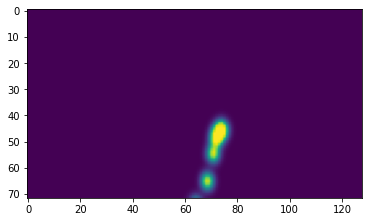

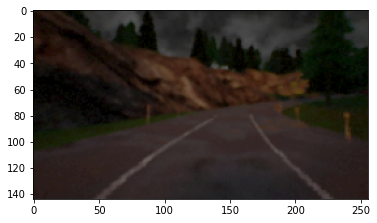

In [ ]:
train_gen = My_Generator(image_dirs[15000:],command_dirs[15000:],label_dirs[15000:],batch_size=12)
valid_gen = My_Generator(valid_image_dirs,valid_command_dirs,valid_label_dirs,train=False)
[images,commands],label = train_gen.__getitem__(2)
print(label.shape)
plt.imshow(label[1])
plt.show()
plt.imshow(np.array(images[1][:,:,:3],dtype=np.uint8))

In [ ]:
net = effn(include_top=False,input_shape=(144,256,9),weights=None)

/usr/local/lib/python3.6/dist-packages/keras_applications/imagenet_utils.py:279: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  str(input_shape[-1]) + ' input channels.')


In [ ]:
def create_model(out_size):
    command = Input((out_size[0],out_size[1],6))
    c1 = net.get_layer("block5c_activation").output
    u1 = UpSampling2D((2,2))(c1)
    c2 = Conv2D(512,(3,3),kernel_initializer = 'glorot_uniform',padding='same',activation='relu')(u1)
    u2 = UpSampling2D((2,2))(c2)
    c3 = Conv2D(128,(3,3),kernel_initializer = 'glorot_uniform',padding='same',activation='relu')(u2)
    u3 = UpSampling2D((2,2))(c3)
    c4 = Conv2D(6,(3,3),kernel_initializer = 'glorot_uniform',padding='same',activation='sigmoid')(u3)
    final = tf.multiply(c4,command)
    final = tf.reduce_sum(final,axis=-1)
    model = Model([net.input,command],final)
    return model
model = create_model((72,128,6))

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 144, 256, 9) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 72, 128, 32)  2592        input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 72, 128, 32)  128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 72, 128, 32)  0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [ ]:
def focal_loss(gamma,gamma2,y_true,y_pred):
    '''focal loss'''
    loglik = y_true*((1-y_pred)**gamma)*K.log(y_pred) +(1-y_true)*(y_pred**gamma2)*K.log(1-y_pred)
    #heatloss=-K.sum(heatmap_true*((1-heatmap_pred)**alpha)*K.log(heatmap_pred+1e-6)+(1-heatmap_true)*((1-heatmap_true_rate)**beta)*(heatmap_pred**alpha)*K.log(1-heatmap_pred+1e-6))
    cls_loss = K.sum(-K.sum(loglik,axis=-1),axis=-1)
    return cls_loss

def loss_fn(gamma1,gamma2):
    '''final combined loss and supporting functions'''
    def final_loss(y_true,y_pred):
        y_pred = K.clip(y_pred,1e-7,1-1e-7)
        cls_loss = focal_loss(gamma1,gamma2,y_true,y_pred)
        return cls_loss
    return final_loss

In [ ]:
model.compile(optimizer=Adam(0.0001),loss=loss_fn(2.0,4.0))
checkpoint = ModelCheckpoint('/content/gdrive/My Drive/model_second2-{epoch:03d}-{val_loss:03f}.h5',monitor = 'val_loss', save_best_only = True, verbose = 1, period = 1)
model.load_weights('/content/gdrive/My Drive/carla_adv/model_on_half_data.h5')

In [ ]:
history = model.fit(train_gen,epochs=20,verbose=1,validation_data=valid_gen,callbacks=[checkpoint])

Epoch 1/20
1067/1067 [==============================] - ETA: 0s - loss: 17.6419
Epoch 00001: val_loss improved from inf to 16.89371, saving model to /content/gdrive/My Drive/model_second2-001-16.893705.h5
1067/1067 [==============================] - 7076s 7s/step - loss: 17.6419 - val_loss: 16.8937
Epoch 2/20
1067/1067 [==============================] - ETA: 0s - loss: 16.8201
Epoch 00002: val_loss did not improve from 16.89371
1067/1067 [==============================] - 183s 172ms/step - loss: 16.8201 - val_loss: 17.0010
Epoch 3/20
1067/1067 [==============================] - ETA: 0s - loss: 16.2805
Epoch 00003: val_loss did not improve from 16.89371
1067/1067 [==============================] - 178s 167ms/step - loss: 16.2805 - val_loss: 17.1108
Epoch 4/20
1067/1067 [==============================] - ETA: 0s - loss: 15.9614
Epoch 00004: val_loss did not improve from 16.89371
1067/1067 [==============================] - 179s 167ms/step - loss: 15.9614 - val_loss: 17.3526
Epoch 5/20
10

KeyboardInterrupt: ignored

In [ ]:
model.load_weights('/content/gdrive/My Drive/carla_adv/model2-014-17.391245.h5')

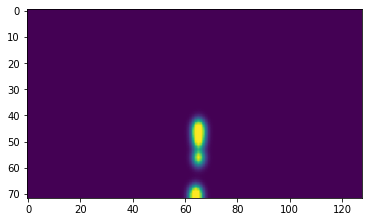

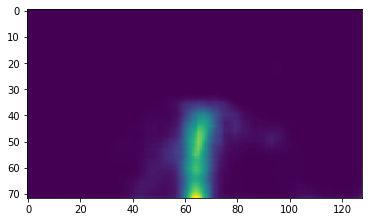

In [ ]:
[t_images,t_commands],t_label = valid_gen.__getitem__1
i = random.sample([j for j in range(32)],k=1)
i = i[0]
t_label_pred = model.predict([t_images[i,:,:,:].reshape(-1,144,256,9),t_commands[i,:,:,:].reshape(-1,72,128,6)])
t_label_pred = t_label_pred[0]
plt.imshow(t_label[i])
plt.show()
plt.imshow(t_label_pred)
plt.show()

In [ ]:
    final = np.zeros_like(t_label_pred)
    for i in range(t_label_pred.shape[0]):
        c = np.argmax(t_label_pred[i,:])
        final[i,c] = t_label_pred[i,c]
    final[final<0.35] = 0

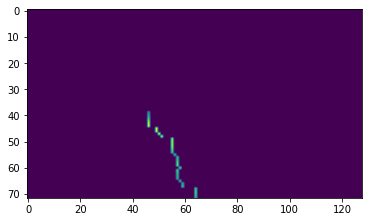

In [ ]:
plt.imshow(final)